# Milk adulteration

load dataset from adulteration.CSV
X.shape (500, 1300)  y.shape (500,)


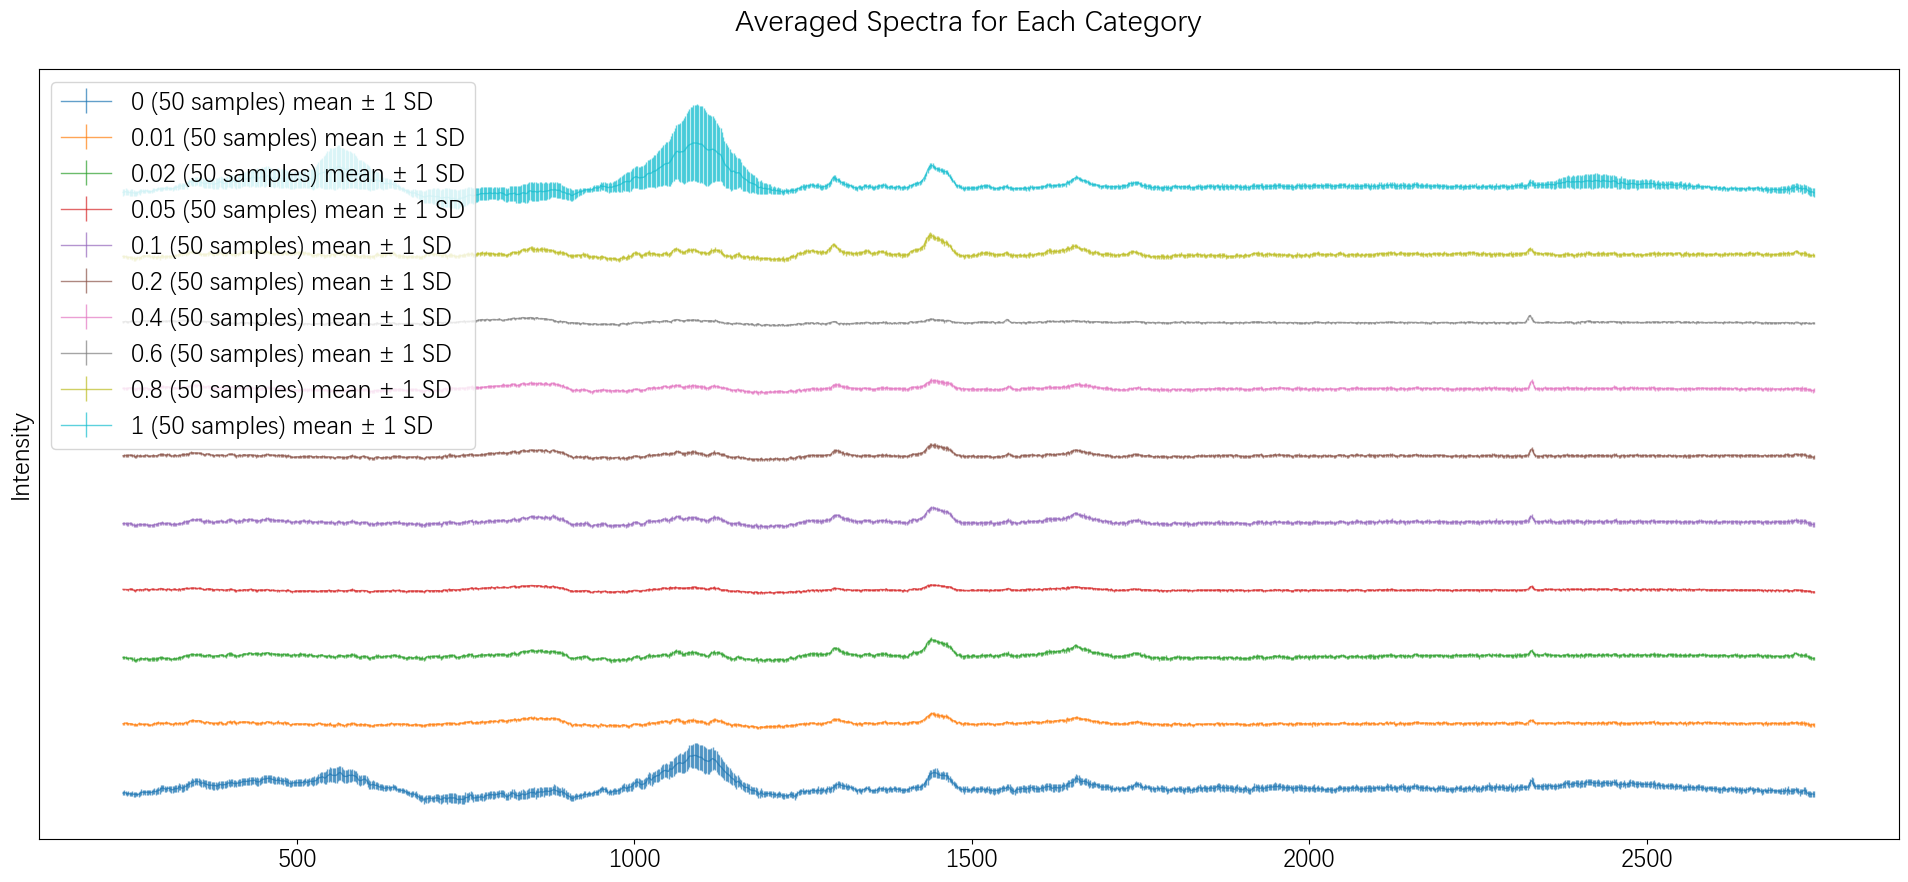

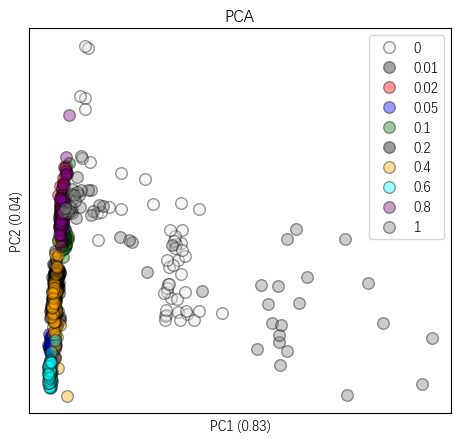

羊奶掺杂不同比例牛奶的拉曼光谱

yangniu0% label=0
yangniu1% label=1
yangniu2% label=2
yangniu5% label=3
yangniu10% label=4
yangniu20% label=5
yangniu40% label=6
yangniu60% label=7
yangniu80% label=8
yangniu100% label=9

"Goat milk is higher in fat and calories when compared to cow milk, and it also contains more protein, vitamins and minerals. 
When compared, goat milk also has about 1% less lactose than cow milk."
goats' milk is almost five times as expensive as cows' milk.  

The goat milk is from M company (Mengyang) and the cow milk is from T company (Telunsu).
No module named 'rpy2'


窗函数预处理（max）: binning window width =  1 / 0.2 = 5


消除基线飘移: baseline removal (regularization = 10000000.0, residual penalty asymetry = 0.01)


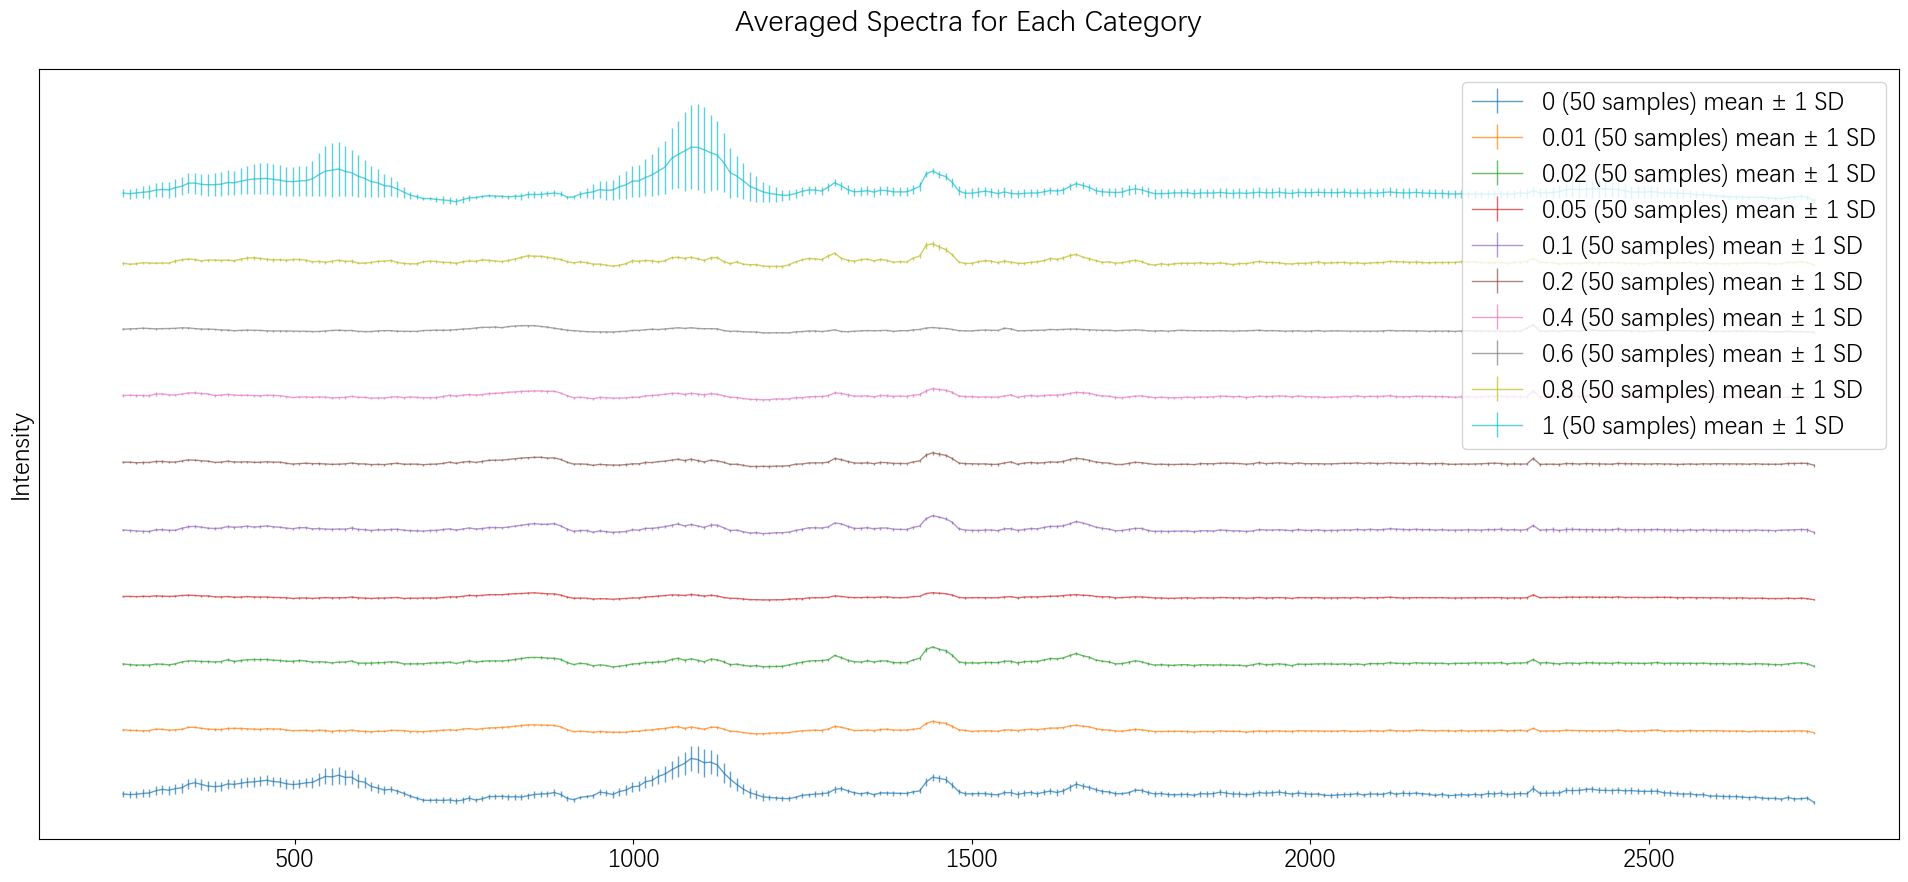

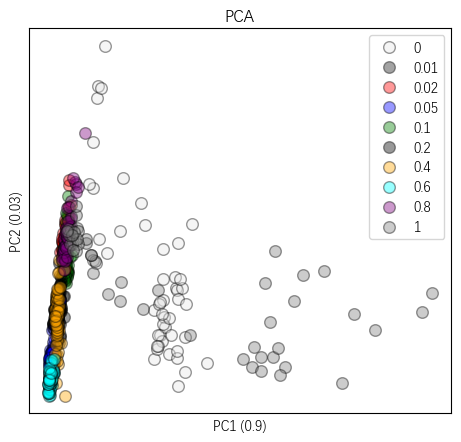

In [1]:
from qsi import io
X, yc, X_names, _, labels = io.load_dataset('milk_adulteration', x_range = list(range(100,1400)), shift=800)

from qsi import pipeline
X, X_names = pipeline.preprocess_dataset(X, X_names, pres = [('max', 0.2),('baseline_removal', (1e7, 1e-2))])
io.draw_class_average(X, yc, X_names, labels=labels, SD=1, shift=800)
_ = io.scatter_plot(X, yc, labels=labels)

## Classification

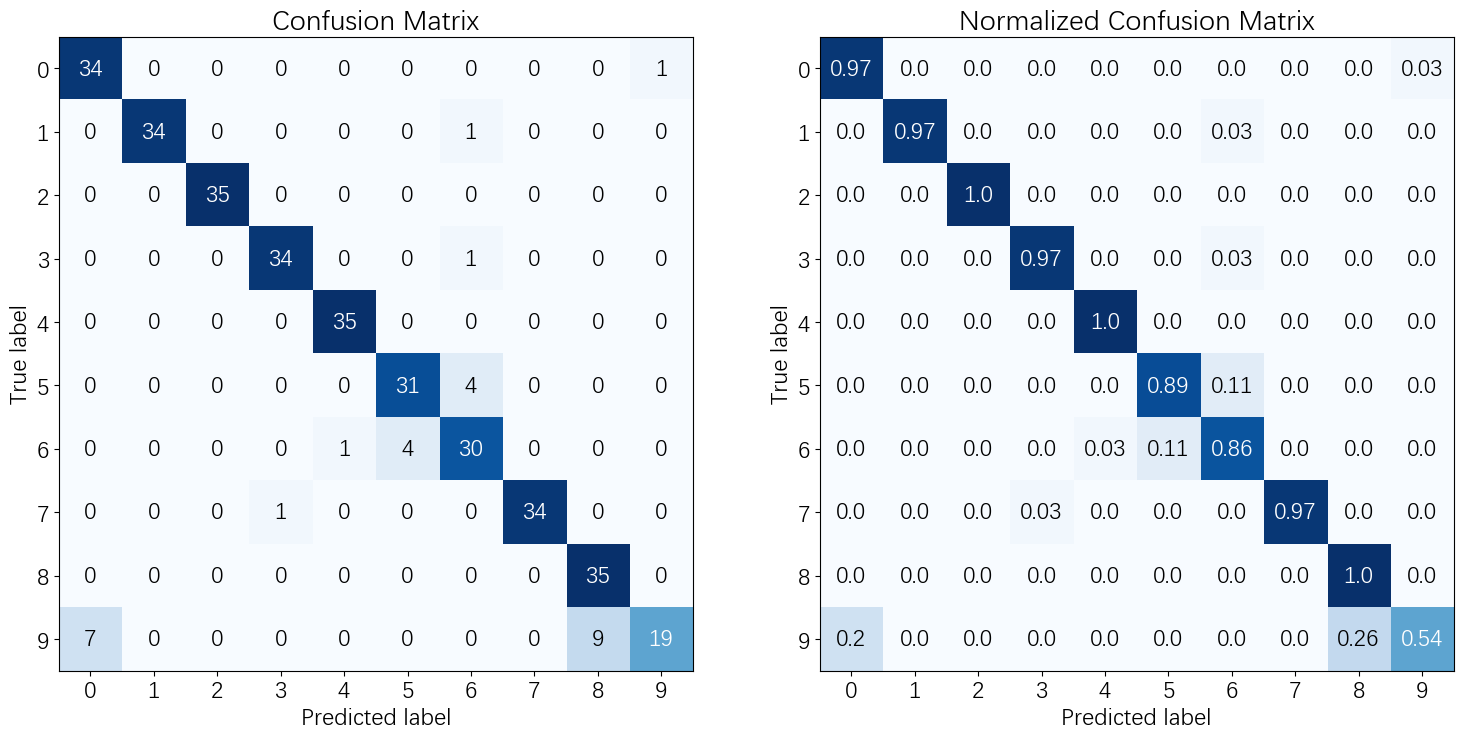

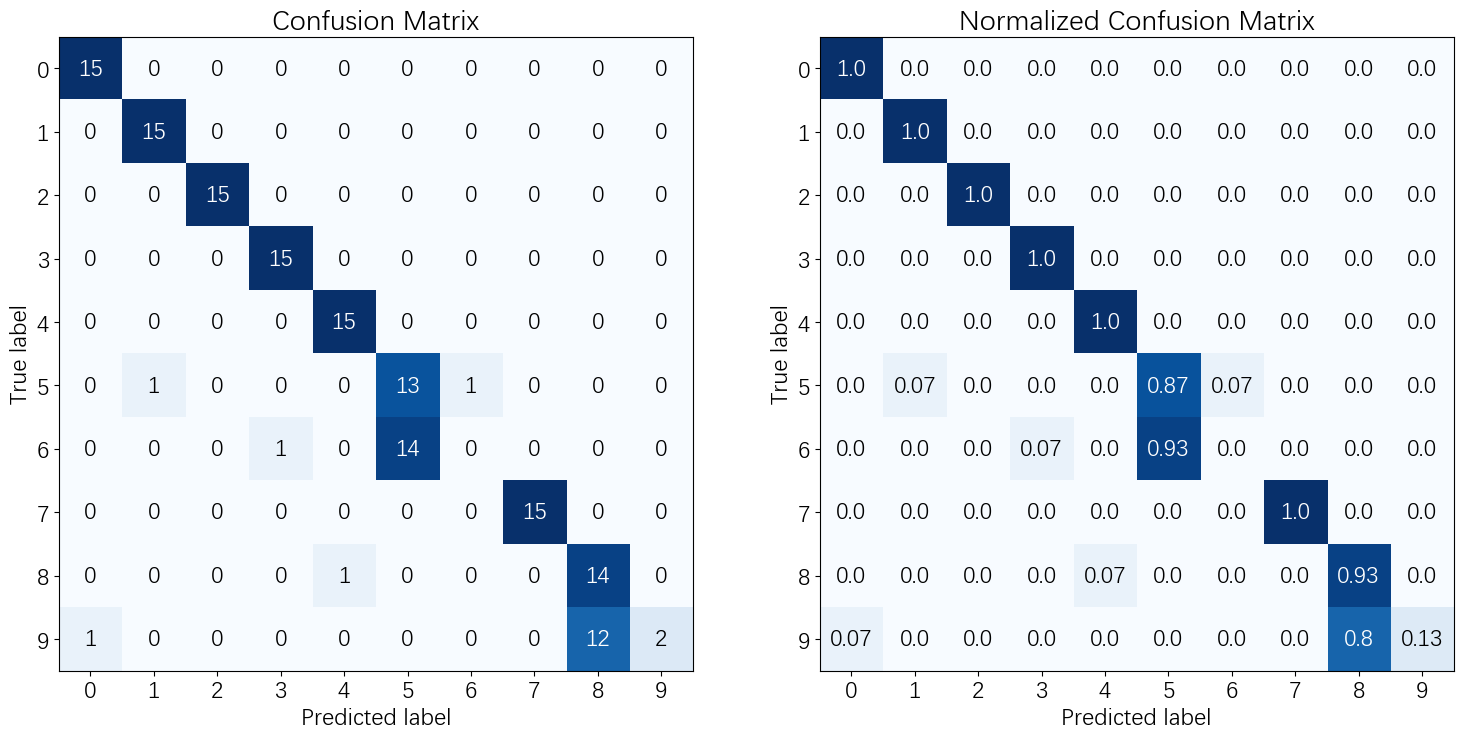

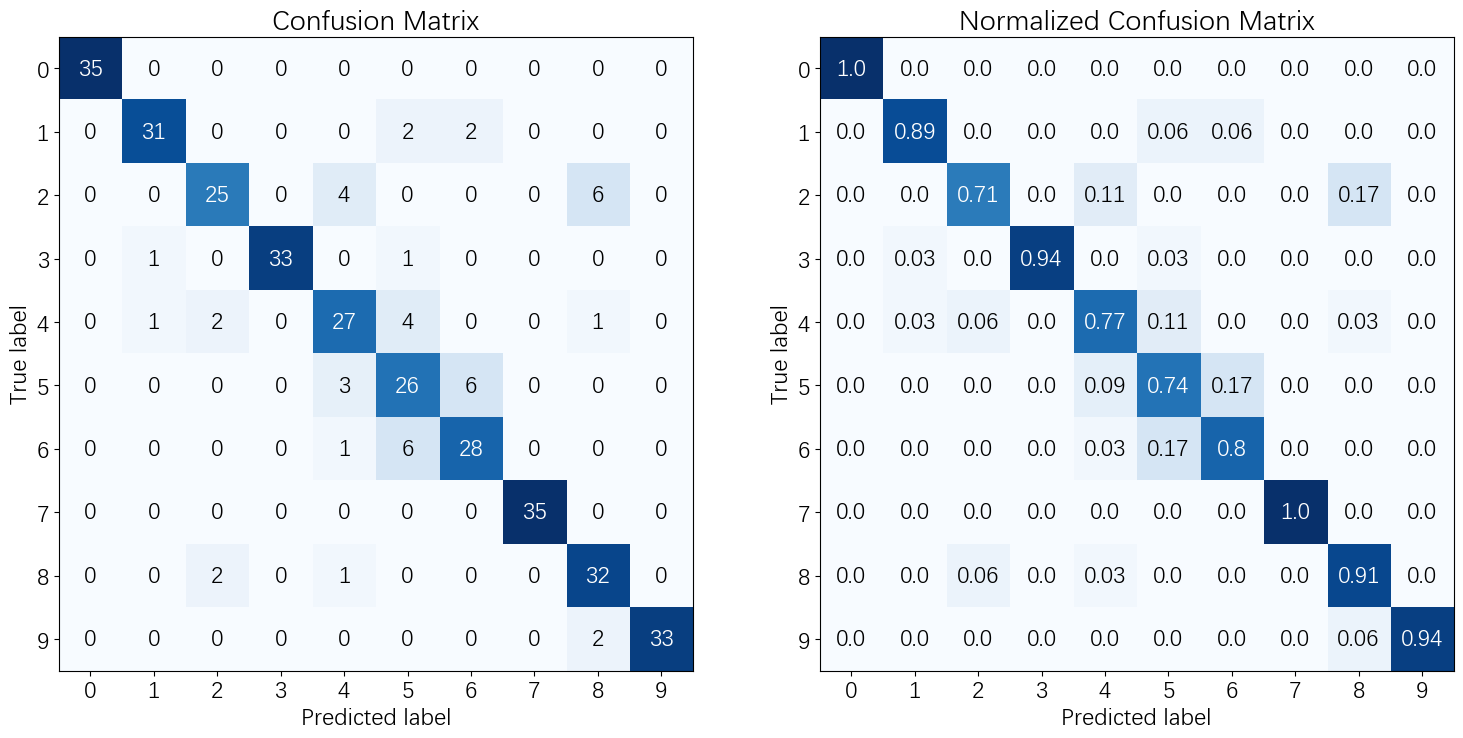

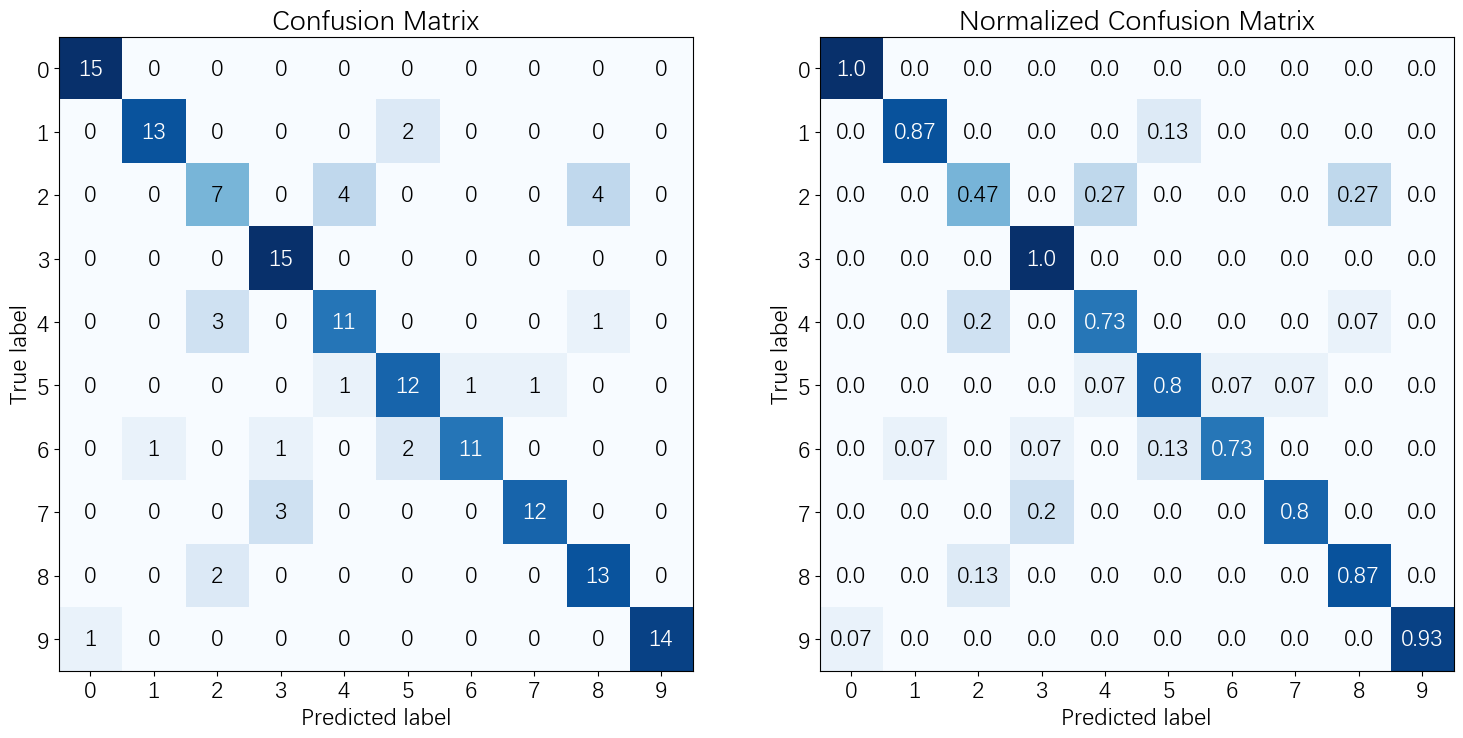

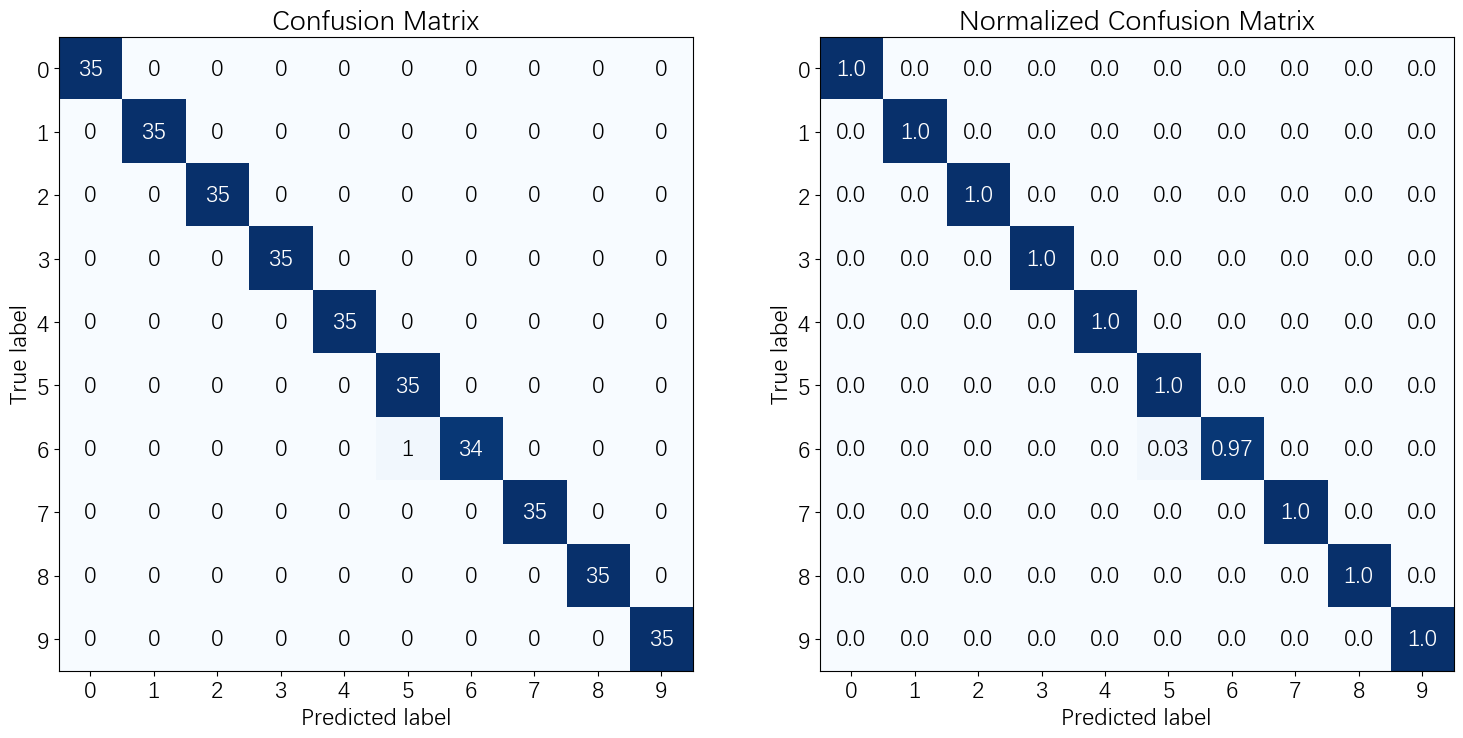

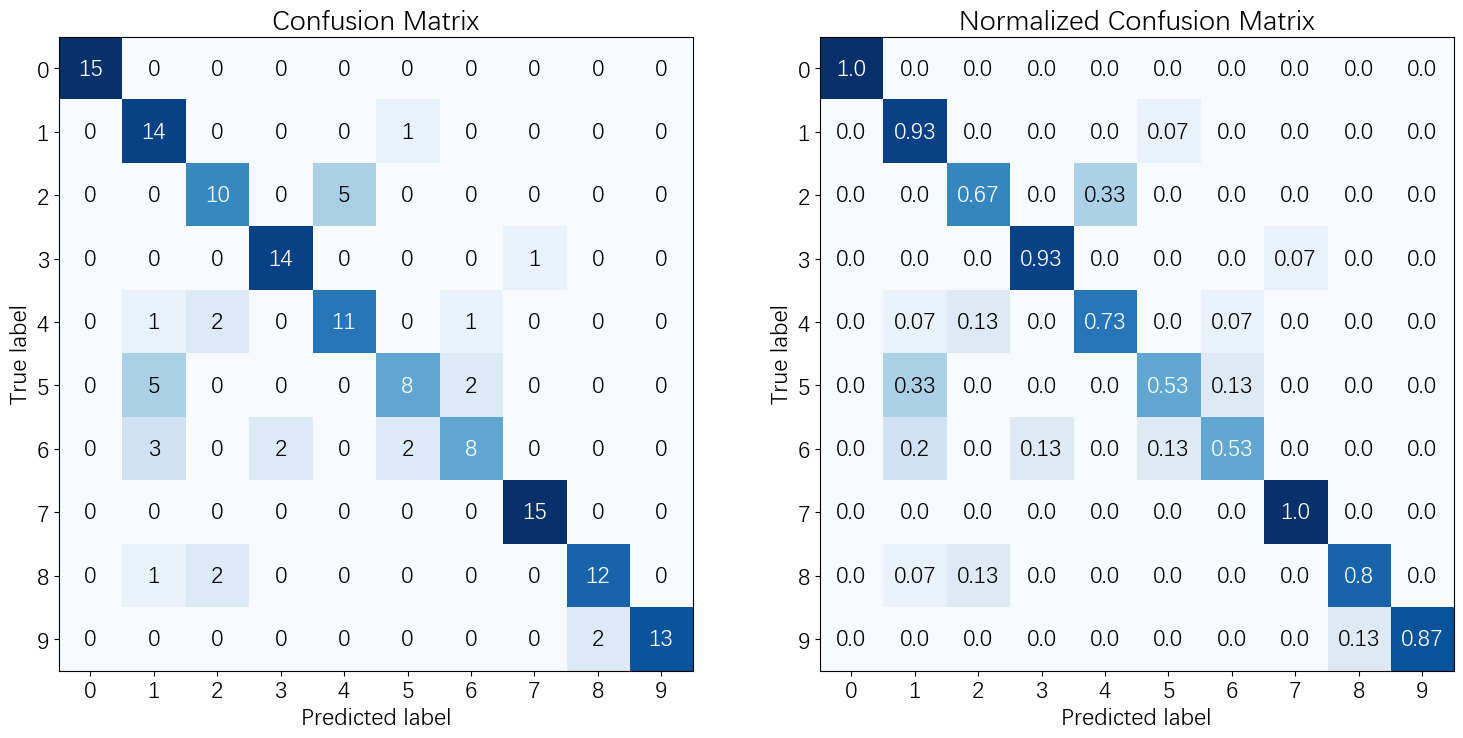

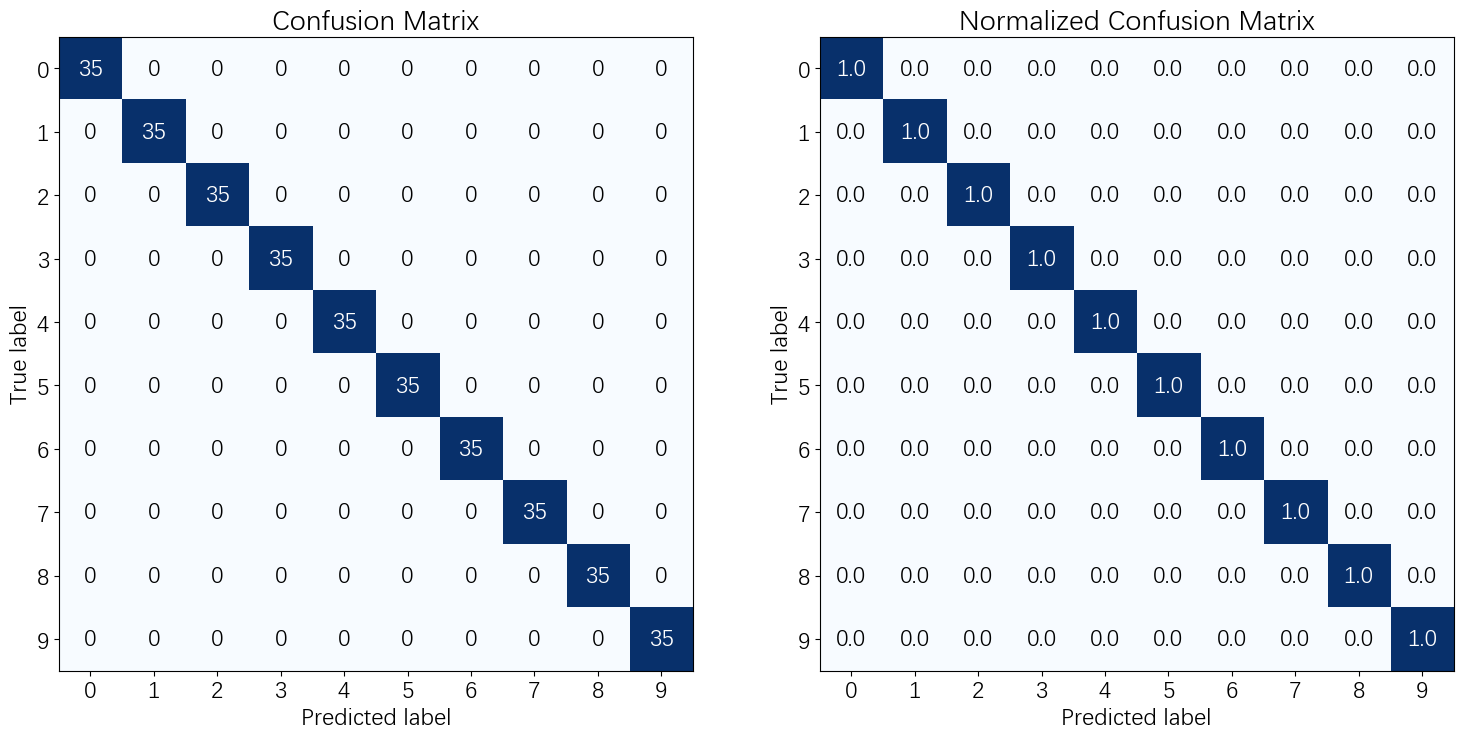

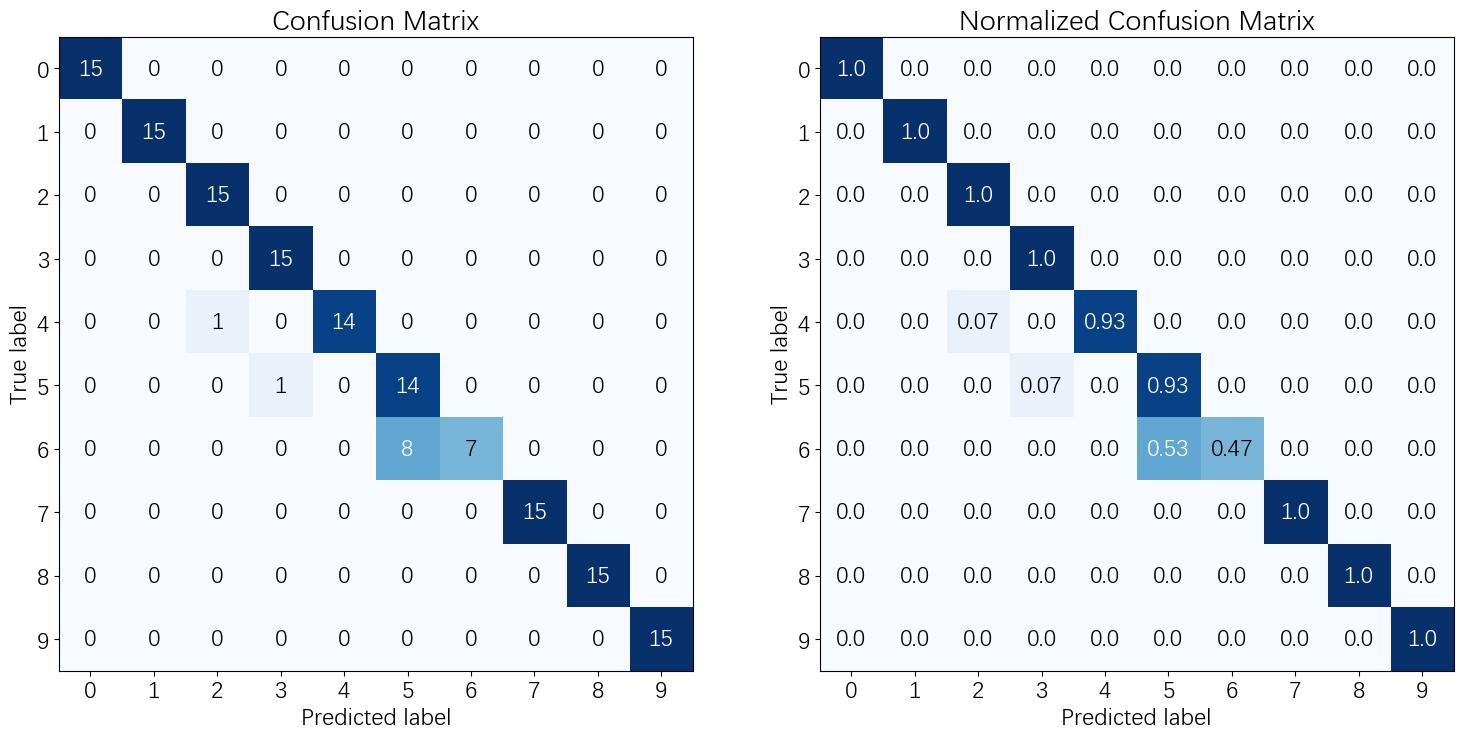

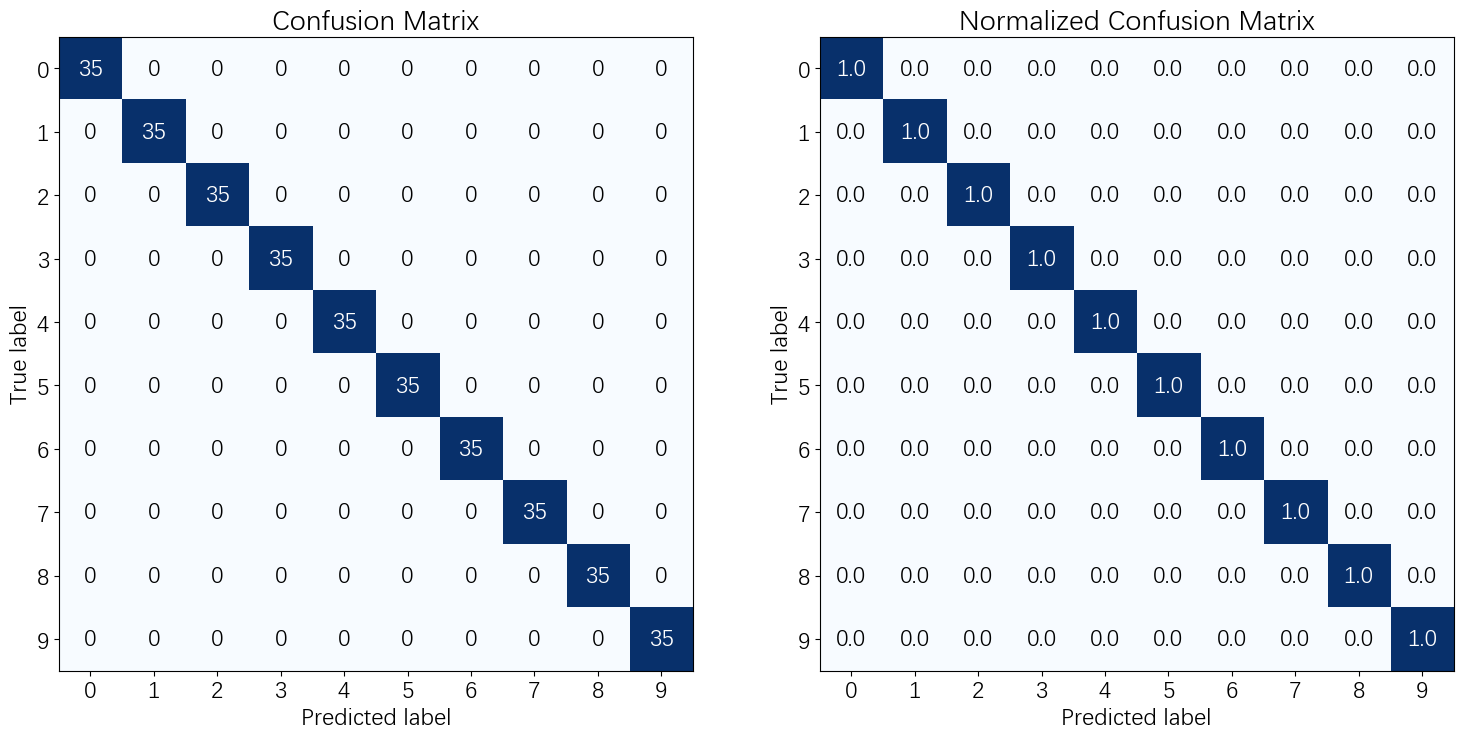

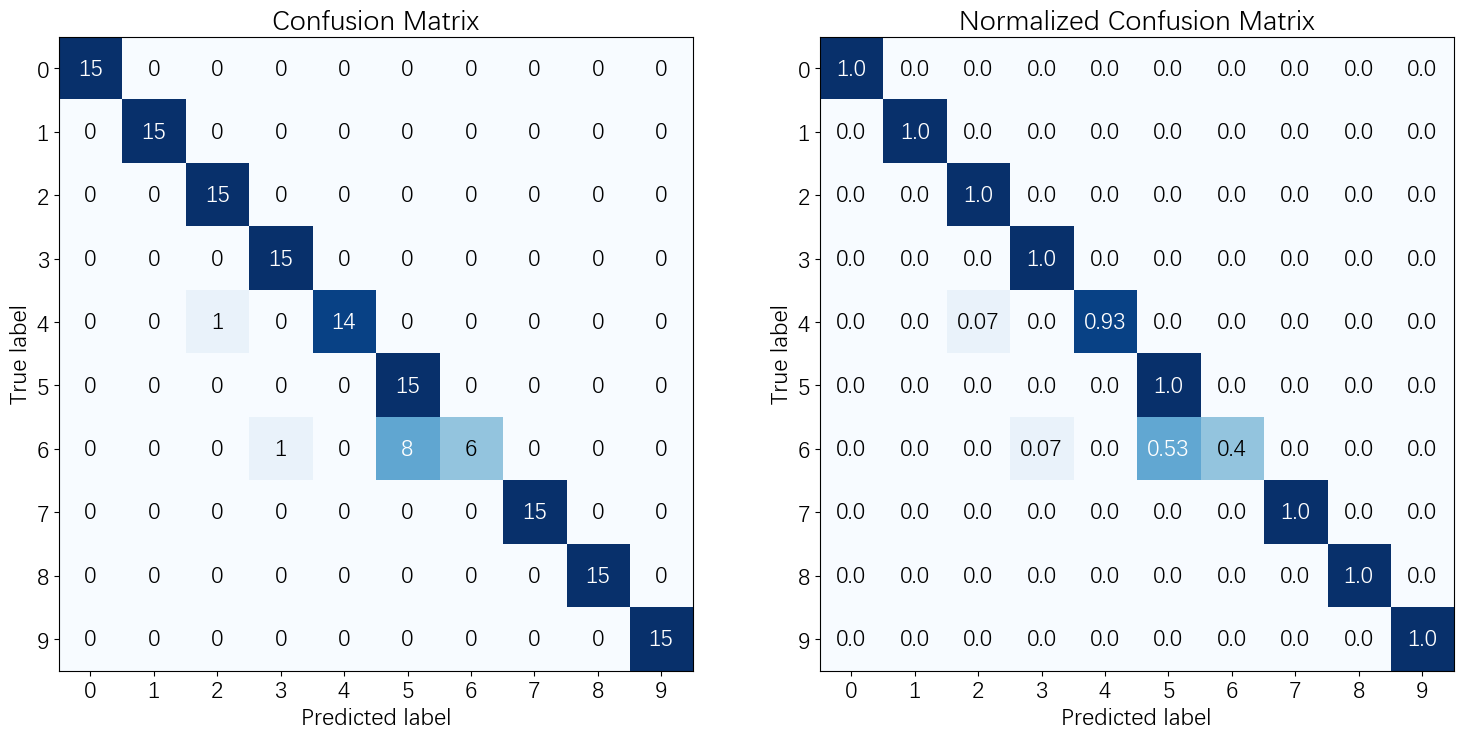

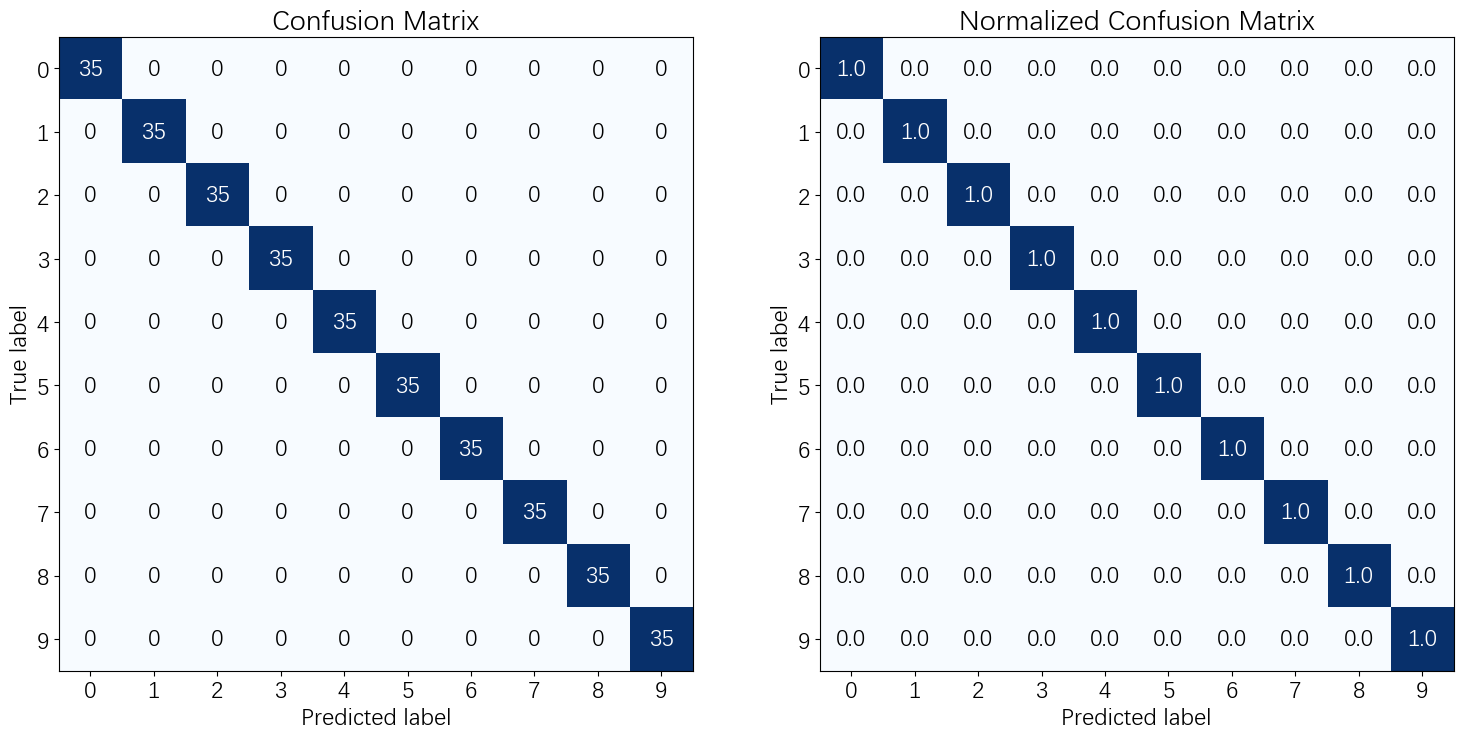

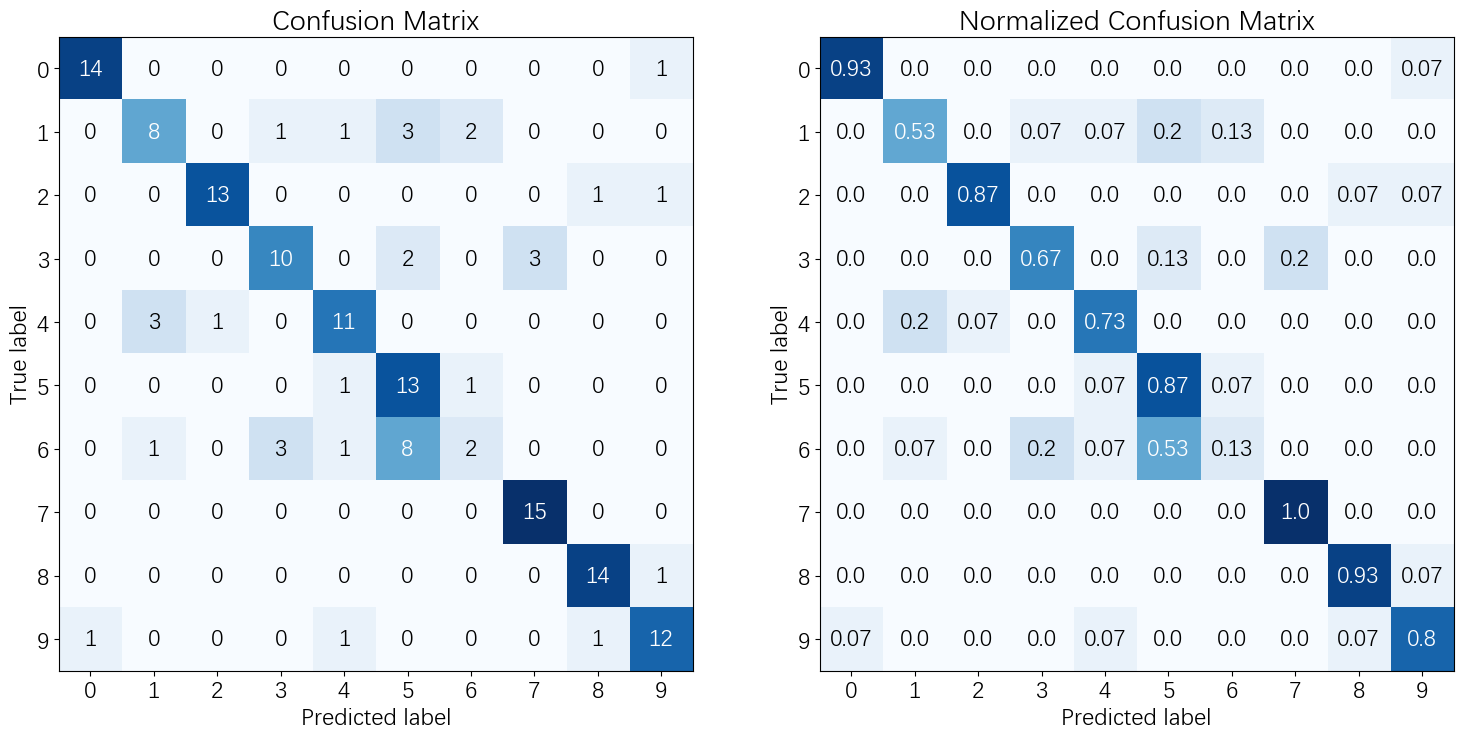

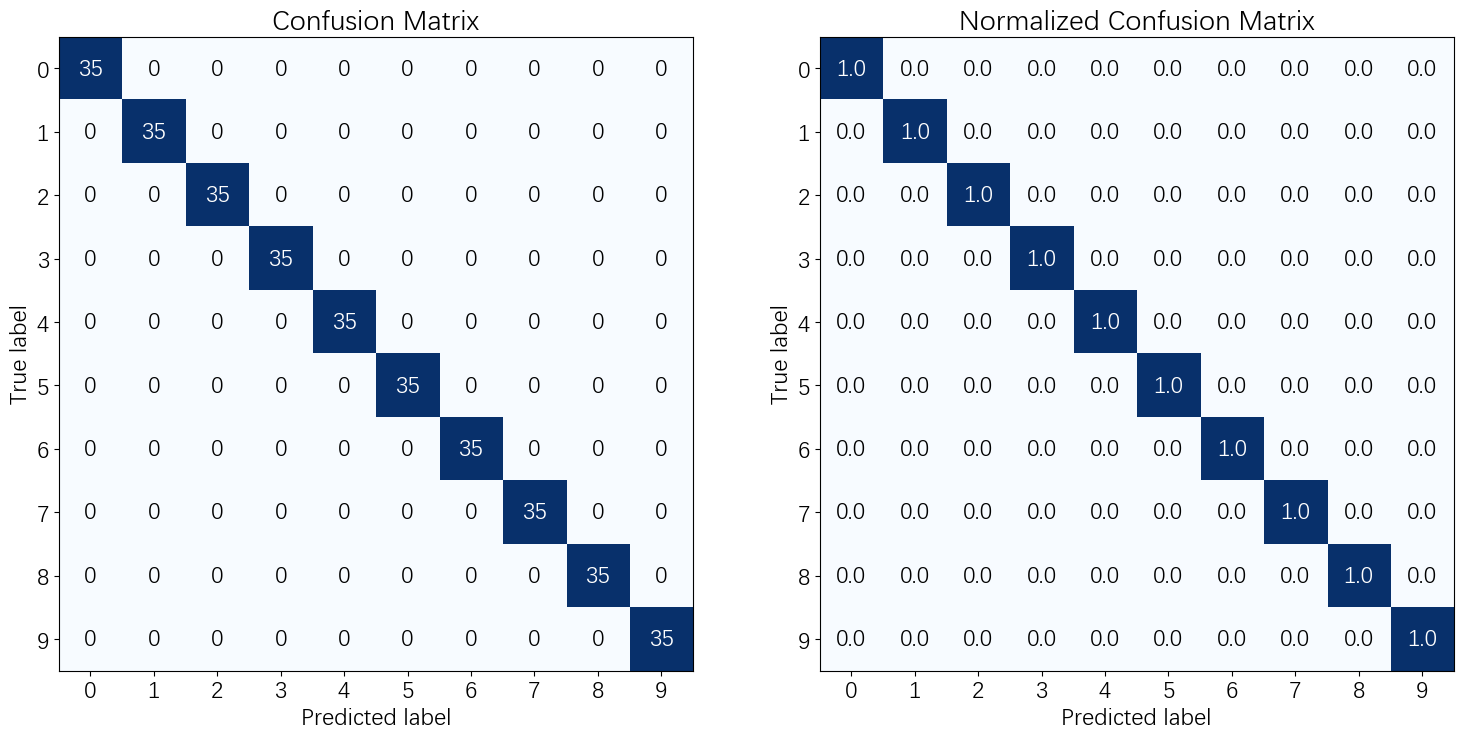

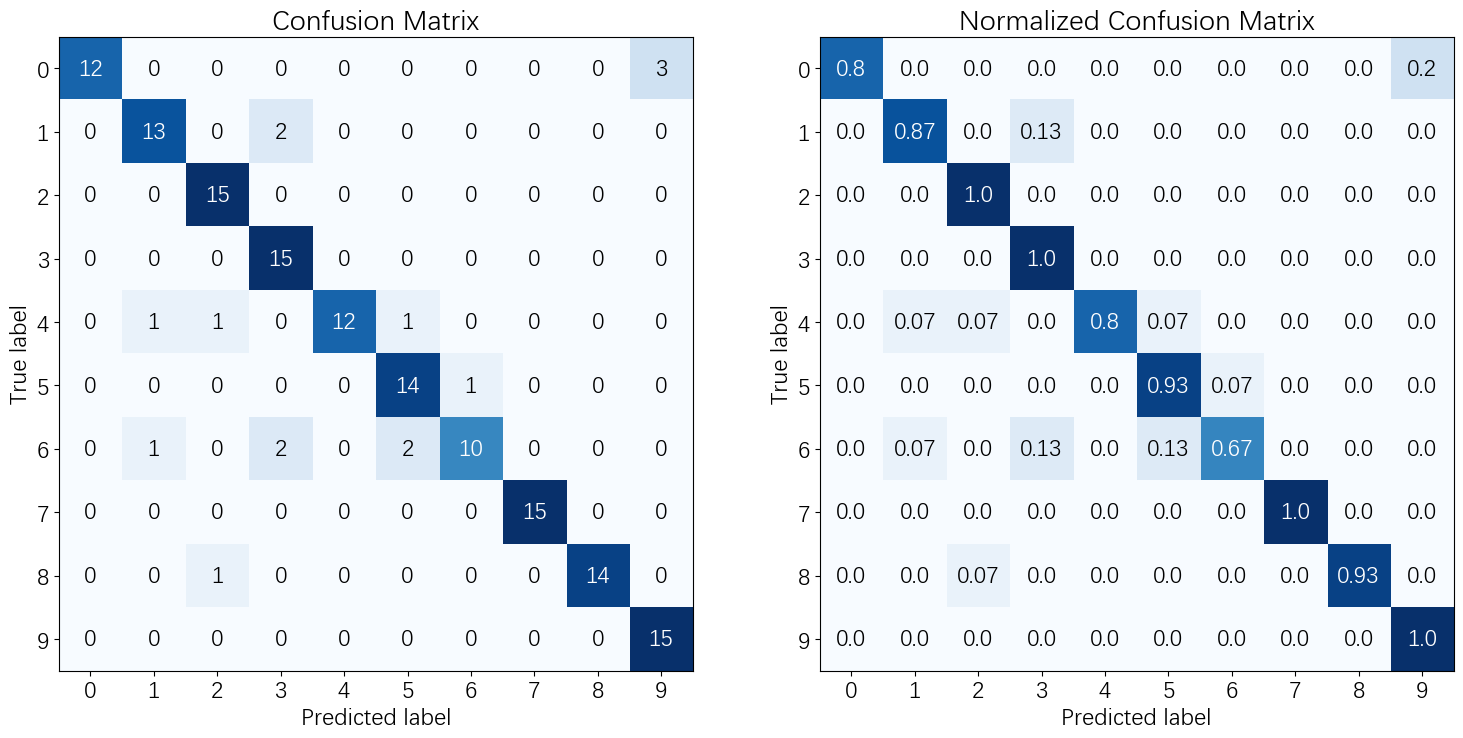

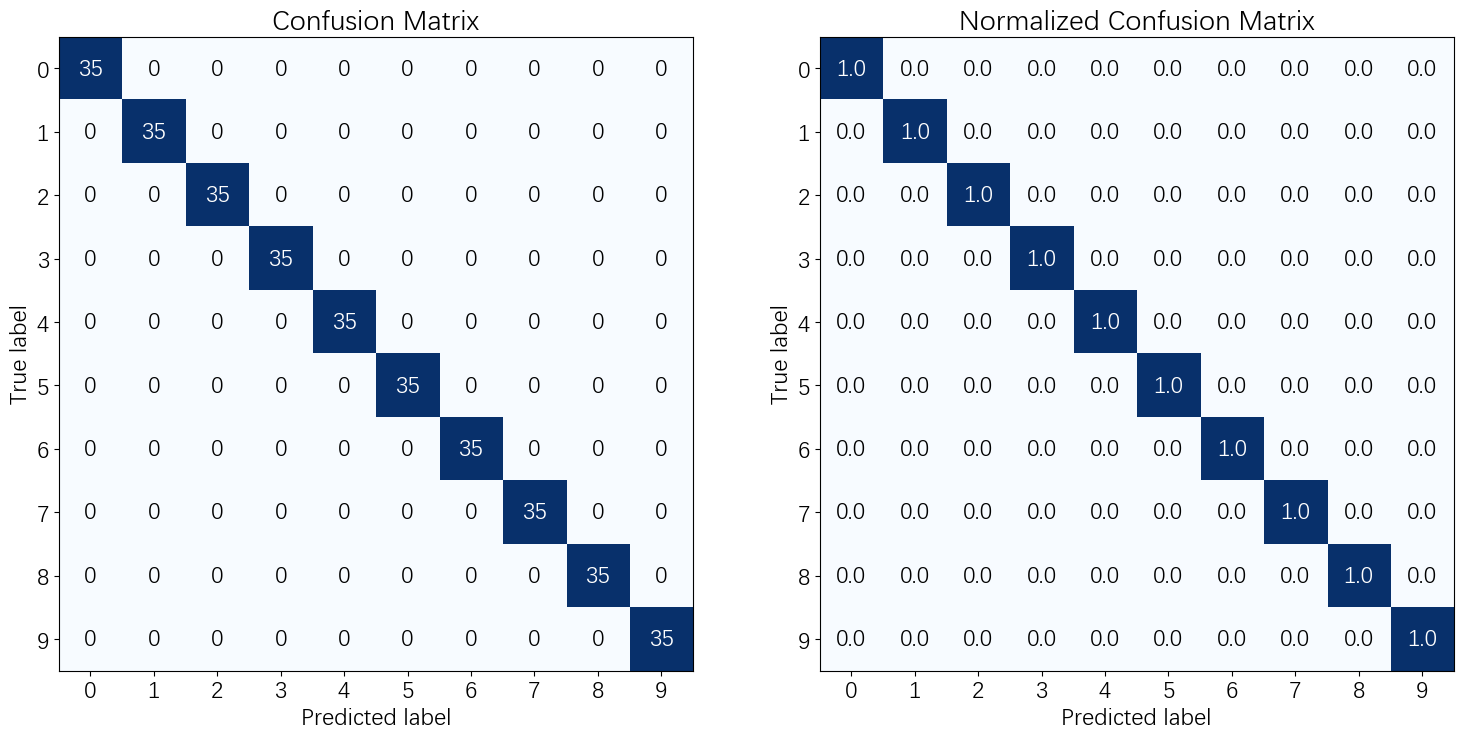

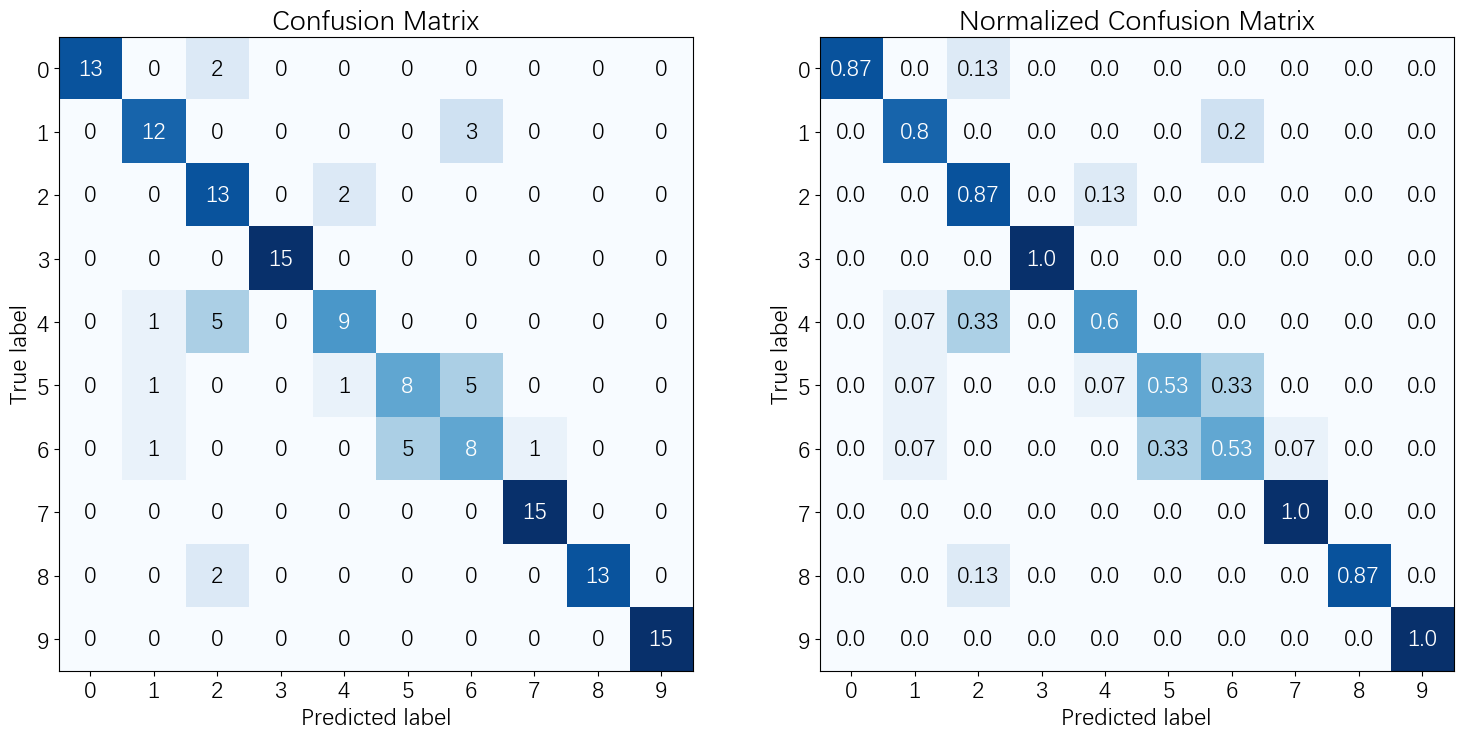

In [2]:
from qsi.cla import run_multiclass_clfs
dic_train_accs, dic_test_accs, html_str = run_multiclass_clfs(X, yc, clfs = 'all', split = .3, split_type = 'ks', cv_seed = 0, show = True)

In [3]:
from qsi.cla import visualize_multiclass_result
_ = visualize_multiclass_result(dic_train_accs, dic_test_accs)

## Regression

In [2]:
import numpy as np
y = np.asfarray(np.array(labels)[yc]) # convert class label to continuous value

In [3]:
from qsi.io.pre import kennardstone_split
idx_train, idx_test = kennardstone_split(X, 0.2)
X_train, X_test = X[idx_train], X[idx_test]
y_train, y_test = y[idx_train], y[idx_test]

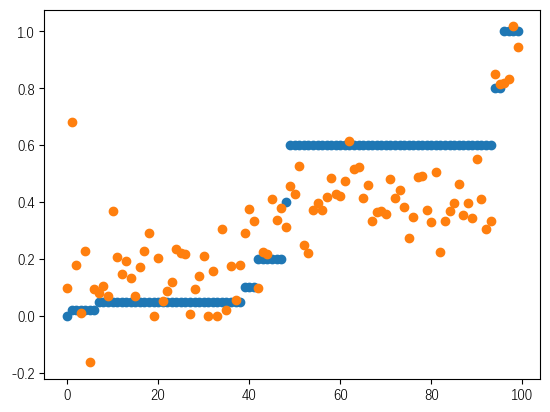

In [8]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

lr = LinearRegression() 
yp = lr.fit(X_train, y_train).predict(X_test])
plt.scatter(range(len(y_test)), y_test)
plt.scatter(range(len(yp)), yp)
plt.show()

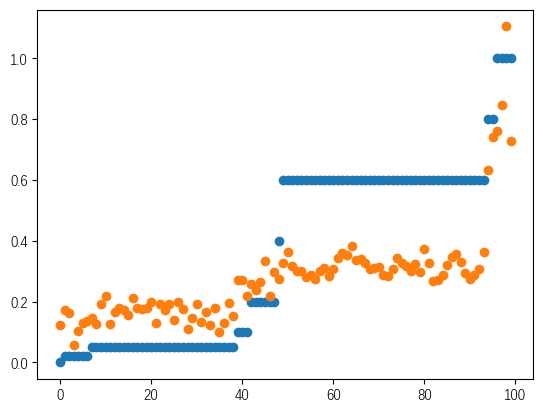

In [16]:
from sklearn.svm import SVR
import matplotlib.pyplot as plt

svr = SVR(kernel = 'rbf') # (kernel="poly", C=100, gamma="auto", degree=2, epsilon=0.1, coef0=1) # (kernel="rbf", C=100, gamma=0.1, epsilon=0.1) 
yp = svr.fit(X_train, y_train).predict(X_test)
plt.scatter(range(len(y_test)), y_test)
plt.scatter(range(len(yp)), yp)
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


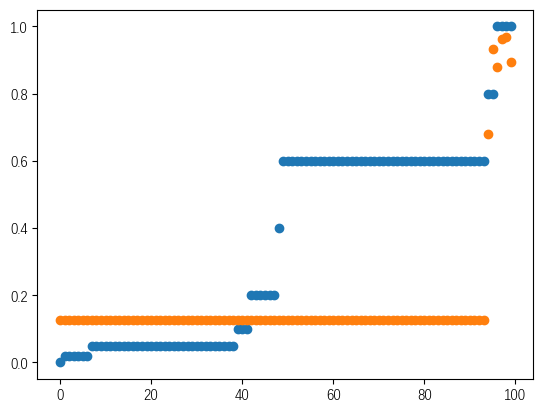

In [18]:
from keras.models import Sequential
from keras.layers import Dense
 
# create ANN model
model = Sequential()
 
# Defining the Input layer and FIRST hidden layer, both are same!
model.add(Dense(units=3, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
 
# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model.add(Dense(units=3, kernel_initializer='normal', activation='tanh'))
 
# The output neuron is a single fully connected node 
# Since we will be predicting a single number
model.add(Dense(1, kernel_initializer='normal'))
 
# Compiling the model
model.compile(loss='mean_squared_error', optimizer='adam')
 
# Fitting the ANN to the Training set
model.fit(X_train, y_train, batch_size = 10, epochs = 200, verbose=0)

yp = model.predict(X_test)
plt.scatter(range(len(y_test)), y_test)
plt.scatter(range(len(yp)), yp)
plt.show()

test score: 0.5553526752850905


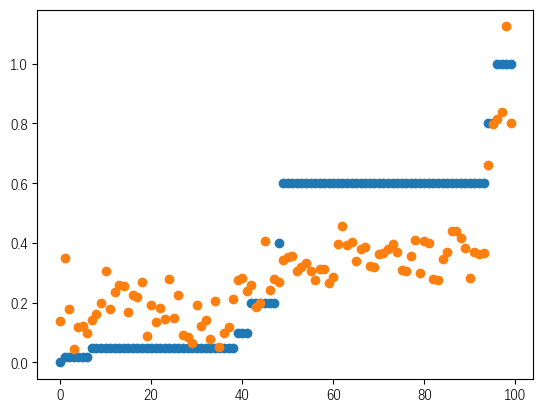

In [7]:
# LASSO
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt

lasso = LassoCV(cv=5).fit(X_train, y_train)
print('test score:', lasso.score(X_test, y_test))

yp = lasso.predict(X_test)
plt.scatter(range(len(y_test)), y_test)
plt.scatter(range(len(yp)), yp)
plt.show()

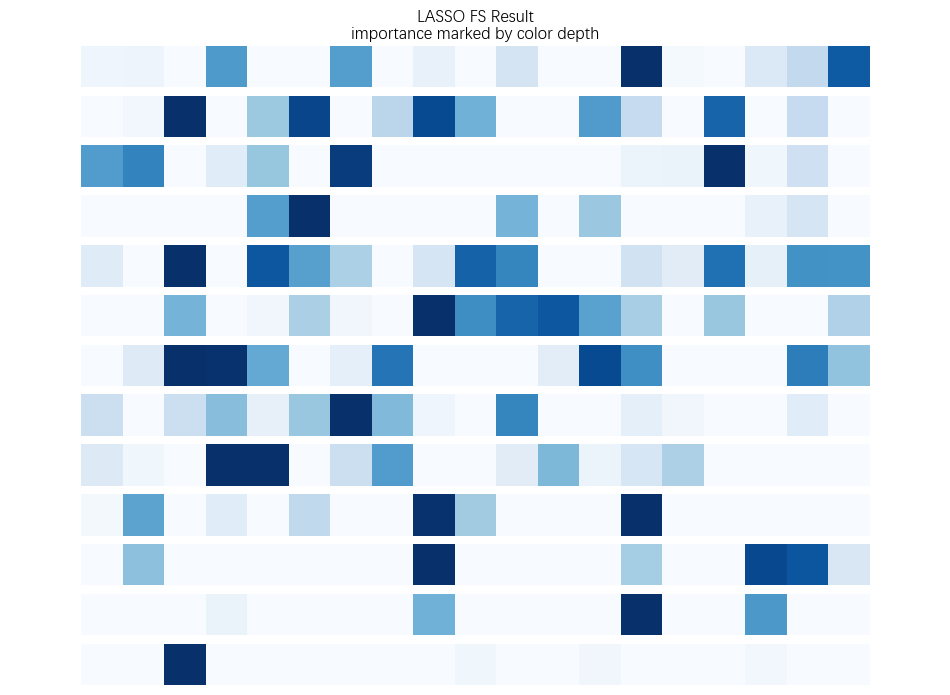

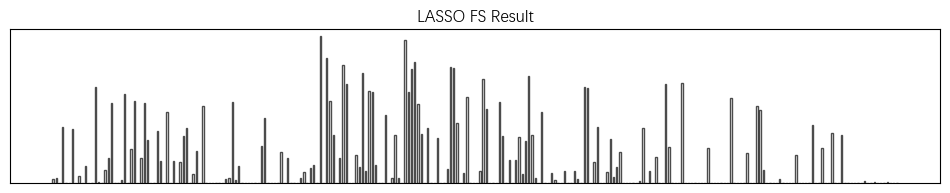

Important feature Number:  125
Important features indices:  [ 82 108  84 111  89 122 123 110  95 146 132 193 188  90 163  13 164  97
 109  98  22 127 208  85  25 137  55  18  28 112  46 216 133 217 150  35
 102  65 124 233   3 167  41 115 181   6  32 239 113  86 105 147 242 138
  40 143 118 171  29 145  64 189 201 236  24  44 174  70 213 228  93 185
  27  17  88  72 140 142  37  33 166  39  99  80  10  57  94 173  79 121
  16 218  96 160 157 131 183  77 170 126 153  43 144   8 172  54  76   1
 148 106 104  53   0 223 161 154  56  21 180 249 252 256  14   9 107]
Important features names:  [1037.246  1287.947  1056.531  1316.874  1104.742  1422.939  1432.582
 1307.231  1162.596  1654.355  1519.363  2107.545  2059.333  1114.385
 1818.275   371.9249 1827.917  1181.881  1297.589  1191.523   458.7059
 1471.151  2252.18   1066.173   487.6329 1567.574   776.903   420.1366
  516.5599 1326.516   690.1219 2329.319  1529.005  2338.961  1692.925
  584.0563 1230.093   873.3263 1442.224  2493.239   2

In [12]:
from qsi.vis import plot_feature_importance

fi = np.abs(lasso.coef_)
plot_feature_importance(fi, X_names, 'LASSO FS Result')

N = (fi!=0).sum()
idx = (np.argsort(fi)[-N:])[::-1]
X_s = X[:, idx]
print('Important feature Number: ', len(idx))
print('Important features indices: ', idx)
if X_names is not None:
    print('Important features names: ', np.array(X_names)[idx])
print('Top-'+str(len(idx))+' feature Importance: ', fi[idx])